<a href="https://colab.research.google.com/github/woodRock/fishy-business/blob/main/code/identification/species/transformer/R01_S01_Species_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
# Hyperparameters
learning_rate = 1E-5 #@param {type:"integer"}
batch_size = 64 # @param {type:"integer"}
epochs = 100 # @param {type:"integer"}
is_next_spectra = False # @param {type:"boolean"}
is_masked_spectra = True # @param {type:"boolean"}

In [88]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from google.colab import drive
import torch
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

drive.mount('/content/drive')
os.listdir('/content/drive/My Drive')

path = ['drive', 'MyDrive', 'AI', 'fish', 'REIMS_data.xlsx']
path = os.path.join(*path)

class CustomDataset(Dataset):
    def __init__(self, samples, labels):
        self.samples = torch.tensor(samples.to_numpy(), dtype=torch.float32)
        self.labels = torch.tensor([np.array(ys) for ys in labels], dtype=torch.float32)
        # Normalize the features to be between in [0,1]
        self.samples = F.normalize(self.samples, dim = 0)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]


print("[INFO] Reading the dataset.")
raw = pd.read_excel(path)

data = raw[~raw['m/z'].str.contains('HM')]
data = data[~data['m/z'].str.contains('QC')]
data = data[~data['m/z'].str.contains('HM')]
X = data.drop('m/z', axis=1) # X contains only the features.
# Onehot encoding for the class labels, e.g. [0,1] for Hoki, [1,0] for Mackeral.
y = data['m/z'].apply(lambda x: [0,1] if 'H' in x else [1,0])
y = np.array(y)

# Evaluation parameters.
train_split = 0.8
val_split = 0.5 # 1/2 of 20%, validation and test, 10% and 10%, respectively.

# Step 2: Split your dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=(1-train_split))
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_split)
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

assert train_dataset.samples.shape[0] == train_dataset.labels.shape[0] , "train_dataset samples and labels should have same length."
assert val_dataset.samples.shape[0] == val_dataset.labels.shape[0] , "train_dataset samples and labels should have same length."
assert test_dataset.samples.shape[0] == test_dataset.labels.shape[0] , "train_dataset samples and labels should have same length."

# Step 4: Create PyTorch DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# calculate steps per epoch for training and validation set
train_steps = len(train_loader.dataset) // batch_size
val_steps = len(val_loader.dataset) // batch_size
# when batch_size greater than dataset size, avoid division by zero.
train_steps = max(1, train_steps)
val_steps = max(1, val_steps)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[INFO] Reading the dataset.


In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert input_dim % num_heads == 0
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads

        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.fc_out = nn.Linear(input_dim, input_dim)

    def forward(self, query, key, value, mask=None):
        """ Attention mechanism (Vaswani 2017)"""
        batch_size = query.shape[0]

        # Split the heads
        Q = self.query(query).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = self.key(key).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = self.value(value).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # Energy-based models
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = F.softmax(energy, dim=-1)

        x = torch.matmul(attention, V)
        x = x.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.input_dim)

        x = self.fc_out(x)
        return x

class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0.1):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_dim)
        # Dropout (Hinton 2012, Srivastava 2014)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # GELU (Hendrycks 2016)
        x = F.gelu(self.fc1(x))
        # Dropout (Hinton 2012, Srivastava 2014)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class EncoderLayer(nn.Module):
    def __init__(self, input_dim, num_heads, hidden_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(input_dim, num_heads)
        self.feed_forward = FeedForward(input_dim, hidden_dim)
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Layer normalization (Ba 2016)
        # Pre-norm formulation (Xiong 2020, Karpathy 2023)
        x_norm = self.norm1(x)
        atttention = self.self_attention(x_norm, x_norm, x_norm, mask)
        # Residual connections (He 2016)
        # Dropout (Srivastava 2014, Hinton 2012)
        x = x + self.dropout1(atttention)
        x_norm = self.norm2(x)
        feed_forward_out = self.feed_forward(x_norm)
        x = x + self.dropout2(feed_forward_out)
        return x

class Encoder(nn.Module):
    def __init__(self, input_dim, num_layers, num_heads, hidden_dim, dropout=0.1):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([EncoderLayer(input_dim, num_heads, hidden_dim, dropout) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return x

class DecoderLayer(nn.Module):
    def __init__(self, input_dim, num_heads, hidden_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(input_dim, num_heads)
        self.cross_attention = MultiHeadAttention(input_dim, num_heads)
        self.feed_forward = FeedForward(input_dim, hidden_dim)
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        """ Attention mechanism (Vasawin 2017)"""
        # Layer normalization (Ba 2016)
        # Pre-norm formulation (Xiong 2020, Karpathy 2023)
        x_norm = self.norm1(x)
        # Self attention (Vaswani 2017)
        attention = self.self_attention(x_norm, x_norm, x_norm, tgt_mask)
        # Residual connections (He 2016)
        # Dropout (Srivastava 2014, Hinton 2012)
        x = x + self.dropout1(attention)
        x_norm = self.norm2(x)
        # Cross attention (Vaswani 2017)
        cross_attention = self.cross_attention(x_norm, encoder_output, encoder_output, src_mask)
        x = x + self.dropout2(cross_attention)
        return x

class Decoder(nn.Module):
    def __init__(self, input_dim, num_layers, num_heads, hidden_dim, dropout=0.1):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList([DecoderLayer(input_dim, num_heads, hidden_dim, dropout) for _ in range(num_layers)])

    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return x

class Transformer(nn.Module):
    """
    References:
    1. Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez,
        A. N., ... & Polosukhin, I. (2017).
        Attention is all you need.
        Advances in neural information processing systems, 30.
    2. He, K., Zhang, X., Ren, S., & Sun, J. (2016).
        Deep residual learning for image recognition.
        In Proceedings of the IEEE conference on
        computer vision and pattern recognition (pp. 770-778).
    3. LeCun, Y. (1989). Generalization and network design strategies.
        Connectionism in perspective, 19(143-155), 18.
    4. LeCun, Y., Boser, B., Denker, J., Henderson, D., Howard,
        R., Hubbard, W., & Jackel, L. (1989).
        Handwritten digit recognition with a back-propagation network.
        Advances in neural information processing systems, 2.
    5. LeCun, Y., Boser, B., Denker, J. S., Henderson, D., Howard, R. E.,
        Hubbard, W., & Jackel, L. D. (1989).
        Backpropagation applied to handwritten zip code recognition.
        Neural computation, 1(4), 541-551.
    6. Hendrycks, D., & Gimpel, K. (2016).
        Gaussian error linear units (gelus).
        arXiv preprint arXiv:1606.08415.
    7. Ba, J. L., Kiros, J. R., & Hinton, G. E. (2016).
        Layer normalization. arXiv preprint arXiv:1607.06450.
    8. Srivastava, N., Hinton, G., Krizhevsky, A.,
        Sutskever, I., & Salakhutdinov, R. (2014).
        Dropout: a simple way to prevent neural networks from overfitting.
        The journal of machine learning research, 15(1), 1929-1958.
    9. Hinton, G. E., Srivastava, N., Krizhevsky, A., Sutskever,
        I., & Salakhutdinov, R. R. (2012).
        Improving neural networks by preventing co-adaptation of feature detectors.
        arXiv preprint arXiv:1207.0580.
    10. Glorot, X., & Bengio, Y. (2010, March).
        Understanding the difficulty of training deep feedforward neural networks.
        In Proceedings of the thirteenth international conference on artificial intelligence and statistics (pp. 249-256).
        JMLR Workshop and Conference Proceedings.
    11. Loshchilov, I., & Hutter, F. (2017).
        Decoupled weight decay regularization.
        arXiv preprint arXiv:1711.05101.
    12. Goodfellow, Ian, Yoshua Bengio, and Aaron Courville.
        Deep learning. MIT press, 2016.
    13. Morgan, N., & Bourlard, H. (1989).
        Generalization and parameter estimation in feedforward nets:
        Some experiments. Advances in neural information processing systems, 2.
    14. Xiong, R., Yang, Y., He, D., Zheng, K.,
        Zheng, S., Xing, C., ... & Liu, T. (2020, November).
        On layer normalization in the transformer architecture.
        In International Conference on Machine Learning (pp. 10524-10533). PMLR.
    14. Karpathy, Andrej (2023)
        Let's build GPT: from scratch, in code, spelled out.
        YouTube https://youtu.be/kCc8FmEb1nY?si=1vM4DhyqsGKUSAdV
    15. Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016).
        Rethinking the inception architecture for computer vision.
        In Proceedings of the IEEE conference on computer vision
        and pattern recognition (pp. 2818-2826).
    16. He, Kaiming, et al. "Delving deep into rectifiers:
        Surpassing human-level performance on imagenet classification."
        Proceedings of the IEEE international conference on computer vision. 2015.
    17. Saxe, A. M., McClelland, J. L., & Ganguli, S. (2013).
        Exact solutions to the nonlinear dynamics of learning in
        deep linear neural networks. arXiv preprint arXiv:1312.6120.
    """

    def __init__(self, input_dim, output_dim, num_layers, num_heads, hidden_dim, dropout=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(input_dim, num_layers, num_heads, hidden_dim, dropout)
        self.decoder = Decoder(input_dim, num_layers, num_heads, hidden_dim, dropout)
        self.fc = nn.Linear(input_dim, output_dim)

        # for name, param in self.named_parameters():
            # if 'weight' in name and param.data.dim() == 2:
                # Xavier weight initialization (Glorot 2010)
                # nn.init.xavier_uniform_(param)
                # Kaiming weight initialization (He 2016)
                # nn.init.kaiming_uniform_(param)
                # Orthogonal weight initialization (Saxe 2013)
                # nn.init.orthogonal_(param)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        x = self.encoder(src, src_mask)
        x = self.decoder(tgt, x, src_mask, tgt_mask)
        x = self.fc(x[:, 0, :])
        return x

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

def pre_train_masked_spectra(model, filepath="next_spectra_model_weights.pth", mask_prob=0.2):
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        model.train()

        for (x,y) in train_loader:
            # Generate batch of data
            tgt_x, x = x.to(device), x.to(device)

            batch_size = x.shape[0]
            mask = torch.rand(batch_size, 1023) < mask_prob
            mask = mask.to(device)
            x[mask] = 0

            optimizer.zero_grad()
            outputs = model(x, x)
            loss = criterion(outputs, tgt_x)  # Compare predicted spectra with true spectra
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        total_val_loss = 0.0
        model.eval()
        for (x,y) in val_loader:
            tgt_x, x = x.to(device), x.to(device)

            val_batch_size = x.shape[0]
            mask = torch.rand(val_batch_size, 1023) < mask_prob
            mask = mask.to(device)
            x[mask] = 0

            outputs = model(x, x)
            val_loss = criterion(outputs, tgt_x)
            total_val_loss += val_loss.item()

        # Print average loss for the epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/batch_size:.4f}, Val: {val_loss/val_batch_size:.4f}')

    masked_spectra_prediction = model
    torch.save(masked_spectra_prediction.state_dict(), filepath)
    return model

# Define hyperparameters
input_dim = 1023
output_dim = 1023  # Same as input_dim for masked spectra prediction
num_layers = 3
num_heads = 3
hidden_dim = 128
dropout = 0.2
learning_rate = 1E-4
batch_size = 64
num_epochs = 100

if is_masked_spectra:
    # Load the transformer.
    model = Transformer(input_dim, output_dim, num_layers, num_heads, hidden_dim, dropout)
    # Specify the device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Initialize your model, loss function, and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model = pre_train_masked_spectra(model, filepath="next_spectra_model_weights.pth")

Epoch [1/100], Loss: 0.0092, Val: 0.0071
Epoch [2/100], Loss: 0.0078, Val: 0.0063
Epoch [3/100], Loss: 0.0069, Val: 0.0056
Epoch [4/100], Loss: 0.0064, Val: 0.0050
Epoch [5/100], Loss: 0.0058, Val: 0.0047
Epoch [6/100], Loss: 0.0054, Val: 0.0043
Epoch [7/100], Loss: 0.0050, Val: 0.0039
Epoch [8/100], Loss: 0.0046, Val: 0.0037
Epoch [9/100], Loss: 0.0044, Val: 0.0035
Epoch [10/100], Loss: 0.0042, Val: 0.0033
Epoch [11/100], Loss: 0.0040, Val: 0.0033
Epoch [12/100], Loss: 0.0038, Val: 0.0031
Epoch [13/100], Loss: 0.0036, Val: 0.0031
Epoch [14/100], Loss: 0.0034, Val: 0.0029
Epoch [15/100], Loss: 0.0033, Val: 0.0028
Epoch [16/100], Loss: 0.0033, Val: 0.0028
Epoch [17/100], Loss: 0.0031, Val: 0.0027
Epoch [18/100], Loss: 0.0030, Val: 0.0027
Epoch [19/100], Loss: 0.0029, Val: 0.0027
Epoch [20/100], Loss: 0.0028, Val: 0.0025
Epoch [21/100], Loss: 0.0028, Val: 0.0025
Epoch [22/100], Loss: 0.0027, Val: 0.0025
Epoch [23/100], Loss: 0.0026, Val: 0.0024
Epoch [24/100], Loss: 0.0026, Val: 0.0024
E

In [91]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import time

def mask_left_side(input_spectra, mask_prob=0.5):
    """
    Masks the left-hand side of the input spectra tensor.

    Args:
        input_spectra (torch.Tensor): Input spectra tensor of shape (batch_size, 1023).
        mask_prob (float): Probability of masking each element of the left-hand side.

    Returns:
        torch.Tensor: Masked input spectra tensor.
    """
    # Calculate the index to split the tensor
    split_index = input_spectra.shape[0] // 2
    # Mask the left half of the input tensor
    input_spectra[:split_index] = 0
    return input_spectra

def mask_right_side(input_spectra, mask_prob=0.5):
    """
    Masks the right-hand side of the input spectra tensor.

    Args:
        input_spectra (torch.Tensor): Input spectra tensor of shape (batch_size, 1023).
        mask_prob (float): Probability of masking each element of the right-hand side.

    Returns:
        torch.Tensor: Masked input spectra tensor.
    """
    # Calculate the index to split the tensor
    split_index = input_spectra.shape[0] // 2
    # Mask the left half of the input tensor
    input_spectra[split_index:] = 0
    return input_spectra

def pre_train_model_next_spectra(model, filepath="next_spectra_model_weights.pth"):
    # Assume train_loader is your DataLoader containing spectra data
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        num_pairs = 0

        # Iterate over batches in the train_loader
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
            optimizer.zero_grad()

            # Extract spectra from the batch
            (x,y) = batch

            # Randomly choose pairs of adjacent spectra from the same index or different indexes
            pairs = []
            labels = []
            for i in range(len(x)):
                if random.random() < 0.5:
                    # Choose two adjacent spectra from the same index
                    if i < len(x) - 1:
                        # Mask the right side of the spectra
                        left = mask_left_side(x[i])
                        right = mask_right_side(x[i])
                        pairs.append((left, right))
                        labels.append([0,1])
                else:
                    # Choose two spectra from different indexes
                    j = random.randint(0, len(x) - 1)
                    if j != i:
                        left = mask_left_side(x[i])
                        right = mask_right_side(x[j])
                        pairs.append((left, right))
                        labels.append([1,0])

            for (input_spectra, target_spectra), label in zip(pairs, labels):
                # Forward pass
                input_spectra = input_spectra.to(device)
                target_spectra = target_spectra.to(device)
                label = torch.tensor(label).to(device)

                output = model(input_spectra.unsqueeze(0), target_spectra.unsqueeze(0))
                label = label.float()

                loss = criterion(output, label.unsqueeze(0))
                total_loss += loss.item()
                # Backpropagation
                loss.backward()
                optimizer.step()
                num_pairs += 1

        # Calculate average loss for the epoch
        avg_loss = total_loss / num_pairs
        print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")

    next_spectra_model = model
    torch.save(next_spectra_model.state_dict(), filepath)
    return model

def transfer_learning(model, filepath='next_spectra_model_weights.pth', output_dim=2):
    # Load the state dictionary from the checkpoint.
    checkpoint = torch.load(filepath)
    # Modify the 'fc.weight' and 'fc.bias' parameters
    checkpoint['fc.weight'] = checkpoint['fc.weight'][:output_dim]  # Keep only the first 2 rows
    checkpoint['fc.bias'] = checkpoint['fc.bias'][:output_dim] # Keep only the first 2 elements
    # Load the modified state dictionary into the model.
    model.load_state_dict(checkpoint, strict=False)

    return model

# Define hyperparameters
input_dim = 1023  # Example: size of input sequence
output_dim = 2  # Example: number of output classes
num_layers = 3
num_heads = 3
hidden_dim = 128
dropout = 0.2
learning_rate = 1e-5
num_epochs = 50
label_smoothing = 0.1

if is_next_spectra:
    # Initialize the model, criterion, and optimizer
    model = Transformer(input_dim, output_dim, num_layers, num_heads, hidden_dim, dropout)

    # Transfer learning
    if is_masked_spectra:
        model = transfer_learning(model, filepath='next_spectra_model_weights.pth')

    # Label smoothing (Szegedy 2016)
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    # AdamW (Loshchilov 2017)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # Specify the device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print("[INFO] Training the network")
    startTime = time.time()


    # Train the model
    model = pre_train_model_next_spectra(model, filepath='next_spectra_model_weights.pth')

    # finish measuring how long training took
    endTime = time.time()
    print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] Training the network
[INFO] Epoch 1/50, Train Loss: 0.6982, Train Acc: 0.4599, Val Loss: 0.6125, Val Acc: 0.8696
[INFO] Epoch 2/50, Train Loss: 0.6105, Train Acc: 0.6952, Val Loss: 0.5351, Val Acc: 0.8261
[INFO] Epoch 3/50, Train Loss: 0.5431, Train Acc: 0.8289, Val Loss: 0.4933, Val Acc: 0.9565
[INFO] Epoch 4/50, Train Loss: 0.4727, Train Acc: 0.9465, Val Loss: 0.4504, Val Acc: 0.9130
[INFO] Epoch 5/50, Train Loss: 0.4211, Train Acc: 0.9519, Val Loss: 0.3859, Val Acc: 1.0000
[INFO] Epoch 6/50, Train Loss: 0.3615, Train Acc: 0.9733, Val Loss: 0.3349, Val Acc: 1.0000
[INFO] Epoch 7/50, Train Loss: 0.3149, Train Acc: 0.9786, Val Loss: 0.2934, Val Acc: 1.0000
[INFO] Epoch 8/50, Train Loss: 0.2782, Train Acc: 0.9840, Val Loss: 0.2603, Val Acc: 1.0000
[INFO] Epoch 9/50, Train Loss: 0.2442, Train Acc: 0.9893, Val Loss: 0.2408, Val Acc: 1.0000
[INFO] Epoch 10/50, Train Loss: 0.2264, Train Acc: 0.9893, Val Loss: 0.2330, Val Acc: 1.0000
[INFO] Epoch 11/50, Train Loss: 0.2212, Train Acc: 

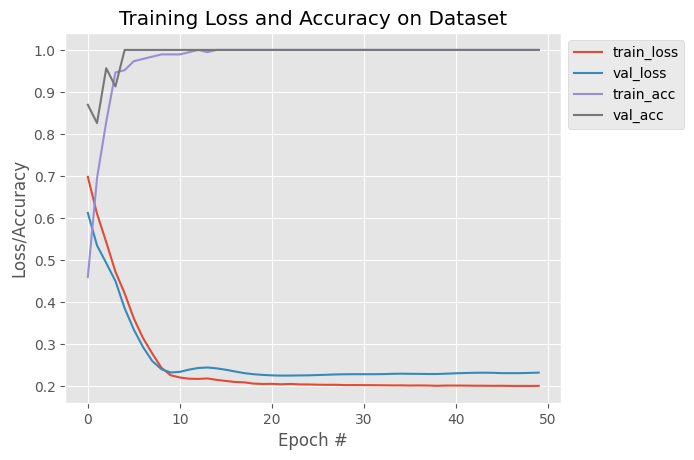

[INFO] total time taken to train the model: 38.98s


In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, inputs, src_mask=None, tgt_mask=None)  # Assuming no masking is needed for now
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == targets.argmax(1)).sum().item()
        total_samples += targets.size(0)

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples

    return epoch_loss, epoch_accuracy

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs, inputs, src_mask=None, tgt_mask=None)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == targets.argmax(1)).sum().item()
            total_samples += targets.size(0)

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples

    return epoch_loss, epoch_accuracy

def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, device):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_dataloader, criterion, optimizer, device)
        val_loss, val_accuracy = evaluate(model, val_dataloader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'[INFO] Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        # Early stopping (Morgan 1989)
        # if train_accuracy == 1 and val_accuracy == 1:
        #     break

    # plot the training loss and accuracy
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(train_losses, label="train_loss")
    plt.plot(val_losses, label="val_loss")
    plt.plot(train_accuracies, label="train_acc")
    plt.plot(val_accuracies, label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.savefig("model_accuracy.png")
    plt.show()

    return train_losses, train_accuracies, val_losses, val_accuracies

def transfer_learning(model, filepath='next_spectra_model_weights.pth', output_dim=2):
    # Load the state dictionary from the checkpoint.
    checkpoint = torch.load(filepath)
    # Modify the 'fc.weight' and 'fc.bias' parameters
    checkpoint['fc.weight'] = checkpoint['fc.weight'][:output_dim]  # Keep only the first 2 rows
    checkpoint['fc.bias'] = checkpoint['fc.bias'][:output_dim] # Keep only the first 2 elements
    # Load the modified state dictionary into the model.
    model.load_state_dict(checkpoint, strict=False)

    return model

# Define hyperparameters
input_dim = 1023  # Example: size of input sequence
output_dim = 2  # Example: number of output classes
num_layers = 3
num_heads = 3
hidden_dim = 128
dropout = 0.2
learning_rate = 1e-5
num_epochs = 50
label_smoothing = 0.1 # (Szegedy 2016)

# Initialize the model, criterion, and optimizer
model = Transformer(input_dim, output_dim, num_layers, num_heads, hidden_dim, dropout)

# Transfer learning
if is_masked_spectra or is_next_spectra:
    model = transfer_learning(model, filepath='next_spectra_model_weights.pth')

# Label smoothing (Szegedy 2016)
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
# AdamW (Loshchilov 2017)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Specify the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("[INFO] Training the network")
startTime = time.time()

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

# finish measuring how long training took
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

In [93]:
model.eval()
# switch off autograd
with torch.no_grad():
    # loop over the test set
    datasets = [("train", train_loader), ("validation", val_loader), ("test", test_loader)]
    for name, dataset in datasets:
        for (x,y) in dataset:
            (x,y) = (x.to(device), y.to(device))
            pred = model(x, x, src_mask=None)
            test_correct = (pred.argmax(1) == y.argmax(1)).sum().item()
            print(f"[INFO] {name} accuracy {test_correct} / {len(x)}")

[INFO] train accuracy 64 / 64
[INFO] train accuracy 64 / 64
[INFO] train accuracy 59 / 59
[INFO] validation accuracy 23 / 23
[INFO] test accuracy 24 / 24


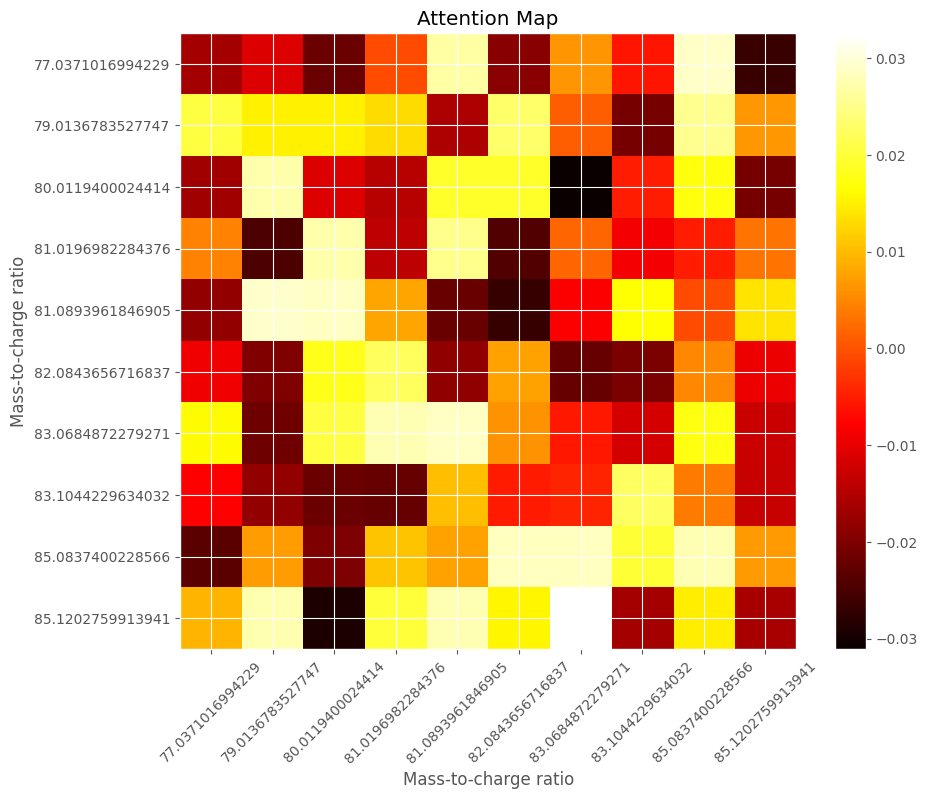

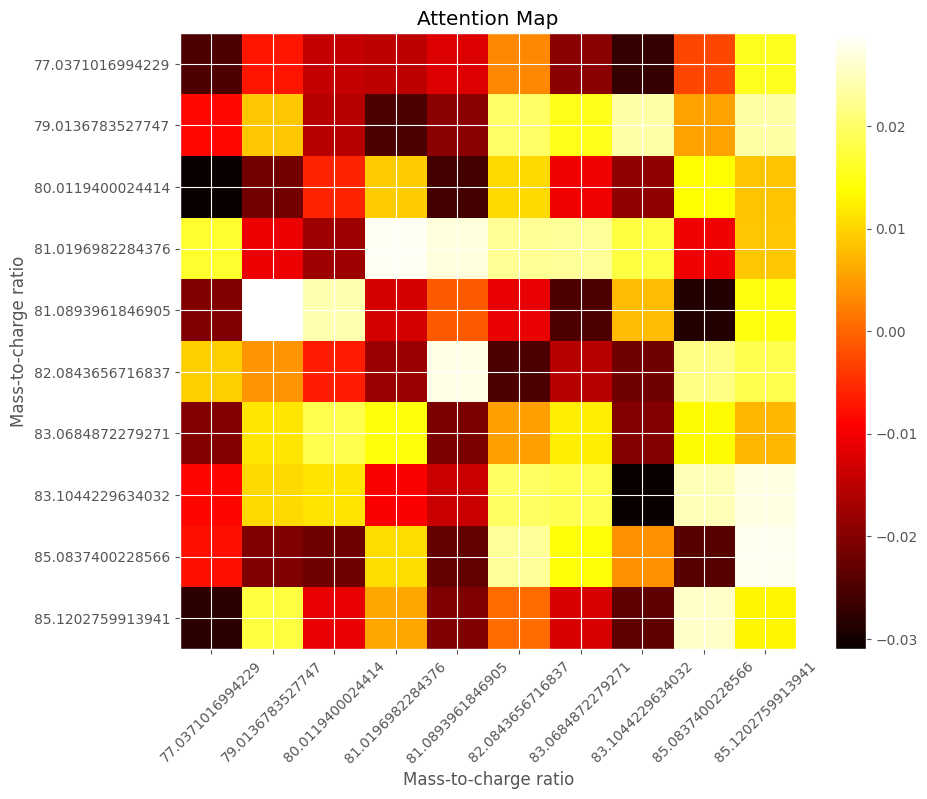

In [94]:
def plot_attention_map(attention_weights, input_tokens, output_tokens):
    # Plot attention weights as a heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(attention_weights, cmap='hot', interpolation='nearest')

    # Set axis labels
    plt.xlabel('Mass-to-charge ratio')
    plt.ylabel('Mass-to-charge ratio')

    # Set axis ticks and labels
    plt.xticks(range(len(output_tokens)), output_tokens, rotation=45)
    plt.yticks(range(len(input_tokens)), input_tokens)

    # Show color bar
    plt.colorbar()

    # Add title
    plt.title('Attention Map')

    # Show plot
    plt.show()

i = 10
columns = data.axes[1][1:(i+1)].tolist()
# First self-attention layer of the encoder.
attention_weights = model.encoder.layers[0].self_attention.fc_out.weight
attention_weights = attention_weights[:i,:i].cpu().detach().numpy()
plot_attention_map(attention_weights, columns, columns)
# Last self-attention layer of the decoder.
attention_weights = model.decoder.layers[-1].self_attention.fc_out.weight
attention_weights = attention_weights[:i,:i].cpu().detach().numpy()
plot_attention_map(attention_weights, columns, columns)